In [2]:
## I'll be making the analysis using SQL (data manipulation) & Pandas (visualization) to show their technical capabilities

import pandas as pd
import sqlite3

df = pd.read_csv('Online Sales Data.csv')
df.head(n=10)

# This data is already cleaned by the Dataset owner in Kaggle

,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal
5,10006,2024-01-06,Sports,Wilson Evolution Basketball,5,29.99,149.95,Asia,Credit Card
6,10007,2024-01-07,Electronics,MacBook Pro 16-inch,1,2499.99,2499.99,North America,Credit Card
7,10008,2024-01-08,Home Appliances,Blueair Classic 480i,2,599.99,1199.98,Europe,PayPal
8,10009,2024-01-09,Clothing,Nike Air Force 1,6,89.99,539.94,Asia,Debit Card
9,10010,2024-01-10,Books,Dune by Frank Herbert,2,25.99,51.98,North America,Credit Card


In [3]:
# Creating a connection between the Dataframe to SQLlite database
conn = sqlite3.connect('ecommerce.db')
df.to_sql('ecommerce', conn, if_exists='replace', index=False)

240

In [39]:
# Checking whether the connections work or not
cursor = conn.cursor() # Creating a cursor object (not mandatory)
query = "SELECT * FROM ecommerce LIMIT 5;"
cursor.execute(query)
rows = cursor.fetchall() # Fetching data from the cursor object
for row in rows:
    print(row) # Return the tuple or rows

with sqlite3.connect('ecommerce.db') as conn:
    df_sql = pd.read_sql_query("SELECT * FROM ecommerce", conn)
    print(df_sql.head(n=5))

(10001, '2024-01-01', 'Electronics', 'iPhone 14 Pro', 2, 999.99, 1999.98, 'North America', 'Credit Card')
(10002, '2024-01-02', 'Home Appliances', 'Dyson V11 Vacuum', 1, 499.99, 499.99, 'Europe', 'PayPal')
(10003, '2024-01-03', 'Clothing', "Levi's 501 Jeans", 3, 69.99, 209.97, 'Asia', 'Debit Card')
(10004, '2024-01-04', 'Books', 'The Da Vinci Code', 4, 15.99, 63.96, 'North America', 'Credit Card')
(10005, '2024-01-05', 'Beauty Products', 'Neutrogena Skincare Set', 1, 89.99, 89.99, 'Europe', 'PayPal')
   Transaction ID        Date Product Category             Product Name  \
0           10001  2024-01-01      Electronics            iPhone 14 Pro   
1           10002  2024-01-02  Home Appliances         Dyson V11 Vacuum   
2           10003  2024-01-03         Clothing         Levi's 501 Jeans   
3           10004  2024-01-04            Books        The Da Vinci Code   
4           10005  2024-01-05  Beauty Products  Neutrogena Skincare Set   

   Units Sold  Unit Price  Total Revenue   

Using SQL, I will be analyzing the following:
1. Sales Performance: by month, by product category, by revenue, by region
2. Payment Method Analysis: pattern by month, pattern by product, AOV per method, revenue contribution per method, sales volume per method
3. Correlation between payment method & AOV
4. Marketing campaigns recomendation


## Sales Performance Analysis

In [5]:
## Total Sales per Month
cursor = conn.cursor()
query_total_sales_per_month = """CREATE TABLE IF NOT EXISTS total_sales_per_month AS
SELECT
    STRFTIME('%Y-%m', "Date") AS month,
    ROUND(SUM("Total Revenue"),2) AS total_sales
FROM ecommerce
GROUP BY month
ORDER BY month"""

# I want to return it as the new table 'total_sales_per_month'
# This will connect to SQLlite database, execute the query, and create table
with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_total_sales_per_month)
    df_total_sales_per_month = pd.read_sql_query("SELECT * FROM total_sales_per_month", conn)
    print(df_total_sales_per_month)

     month  total_sales
0  2024-01     14548.32
1  2024-02     10803.37
2  2024-03     12849.24
3  2024-04     12451.69
4  2024-05      8455.49
5  2024-06      7384.55
6  2024-07      6797.08
7  2024-08      7278.11


<Axes: xlabel='month', ylabel='total_sales'>

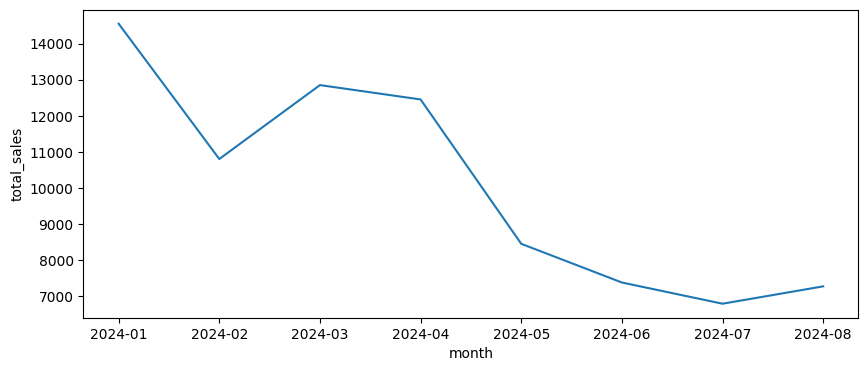

In [6]:
# Checking sales trend for growth opportunities
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.lineplot(x='month', y='total_sales', data=df_total_sales_per_month)

Interpretation on sales trend:


*   The best sales happened in the first half of the year
*   Judging by the type of items we sold, it can be connected to the behavior of making 'big-purchases' at the start of the year as a part of 'new years resolution'
*   The spike in month 3 & 4 can be further investigated. For example - we hypothesize that the spike in month 3 & 4 is from the Asia region due to many festives being held at that month.





In [7]:
## Sales by Product Category
cursor = conn.cursor()
query_sales_by_product_category = """CREATE TABLE IF NOT EXISTS sales_by_product_category AS SELECT
    "Product Category",
    ROUND(SUM("Total Revenue"),2) AS total_sales,
    SUM("Units Sold") AS total_units_sold
FROM ecommerce
GROUP BY "Product Category"
ORDER BY total_sales DESC"""

with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_sales_by_product_category)
    df_sales_by_product_category = pd.read_sql_query("SELECT * FROM sales_by_product_category", conn)
    print(df_sales_by_product_category)

  Product Category  total_sales  total_units_sold
0      Electronics     34982.41                66
1  Home Appliances     18646.16                59
2           Sports     14326.52                88
3         Clothing      8128.93               145
4  Beauty Products      2621.90                46
5            Books      1861.93               114


<Axes: xlabel='Product Category', ylabel='total_units_sold'>

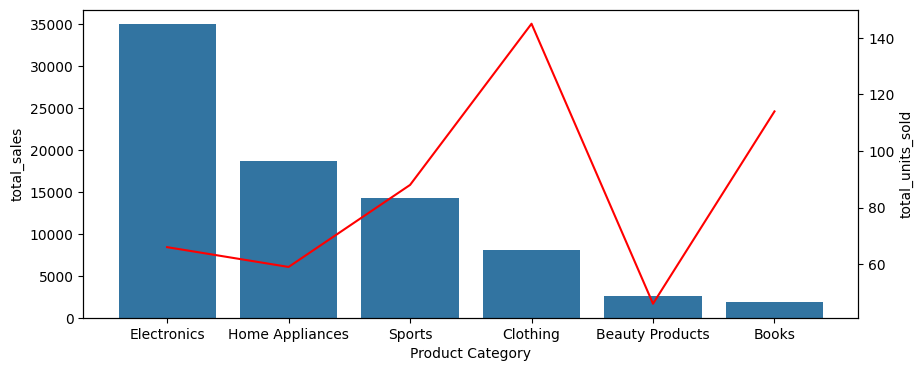

In [8]:
# Visualizing product category performance
plt.figure(figsize=(10, 4))
sns.barplot(x='Product Category', y='total_sales', data=df_sales_by_product_category)
ax2 = plt.gca().twinx()
sns.lineplot(x='Product Category', y='total_units_sold', data=df_sales_by_product_category, ax=ax2, color='red')

Interpretation on product category performance:
*   It's quite hard to judge the performance if we're only looking at 'revenue'. We should collaborate with sales & finance to look at 'margin' per category data
*   For example, Electronics might bring the most revenue without having large inventory, but what about the margin contribution?
*   Books and clothing stock must be tended frequently as they need a lot of stocks but contribute to small number of revenue





In [9]:
## Total Sales By Region By Category
cursor = conn.cursor()
query_sales_by_region_by_product = """CREATE TABLE IF NOT EXISTS sales_by_region_by_product AS
SELECT
    "Region",
    "Product Category",
    ROUND(SUM("Total Revenue"),2) AS total_sales,
    SUM("Units Sold") AS total_units_sold
FROM ecommerce
GROUP BY "Region", "Product Category"
ORDER BY total_sales DESC"""

with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_sales_by_region_by_product)
    df_sales_by_region_by_product = pd.read_sql_query("SELECT * FROM sales_by_region_by_product", conn)
    print(df_sales_by_region_by_product)


          Region Product Category  total_sales  total_units_sold
0  North America      Electronics     34982.41                66
1         Europe  Home Appliances     18646.16                59
2           Asia           Sports     14326.52                88
3           Asia         Clothing      8128.93               145
4         Europe  Beauty Products      2621.90                46
5  North America            Books      1861.93               114


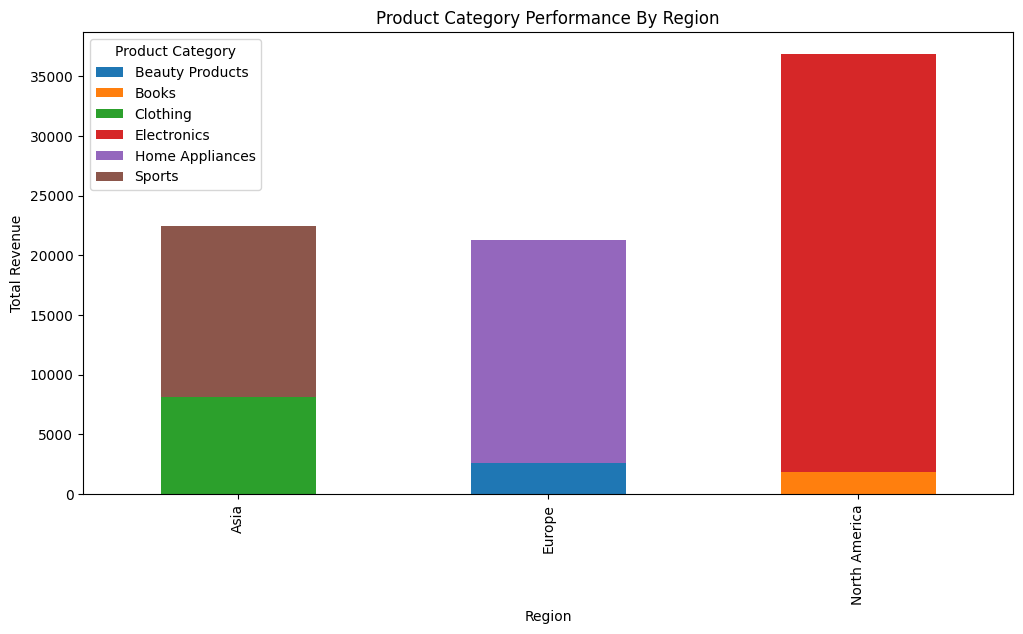

In [10]:
# Plot the distribution of sales (revenue) across regions and product
category_region_sales = df.groupby(['Region', 'Product Category'])['Total Revenue'].sum().unstack()
category_region_sales .plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Product Category Performance By Region')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.legend(title='Product Category')
plt.show()

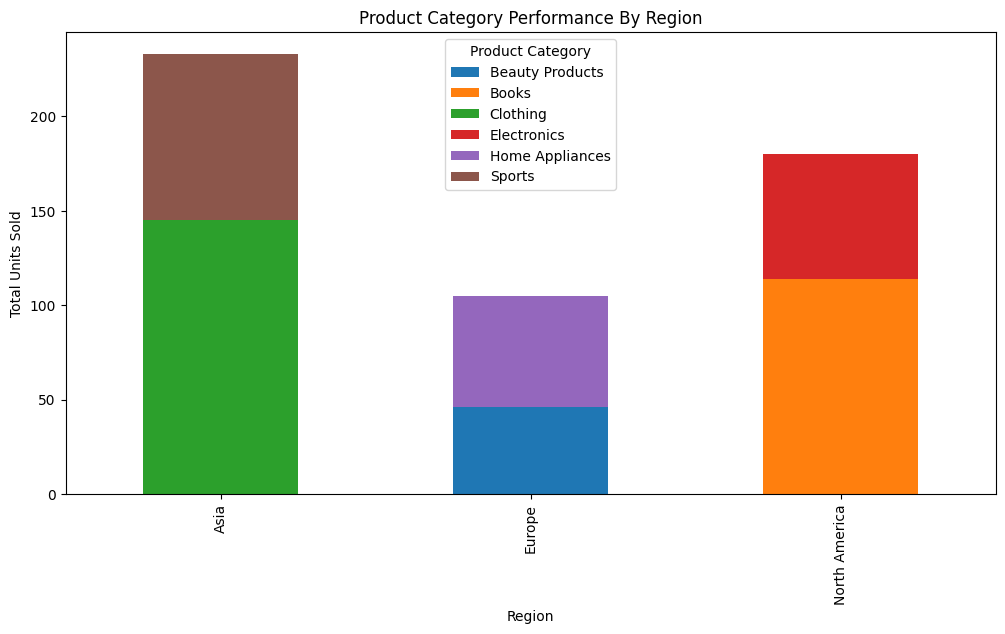

In [11]:
# Plot the distribution of sales (units sold) across regions and product
category_region_sales = df.groupby(['Region', 'Product Category'])['Units Sold'].sum().unstack()
category_region_sales .plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Product Category Performance By Region')
plt.xlabel('Region')
plt.ylabel('Total Units Sold')
plt.legend(title='Product Category')
plt.show()

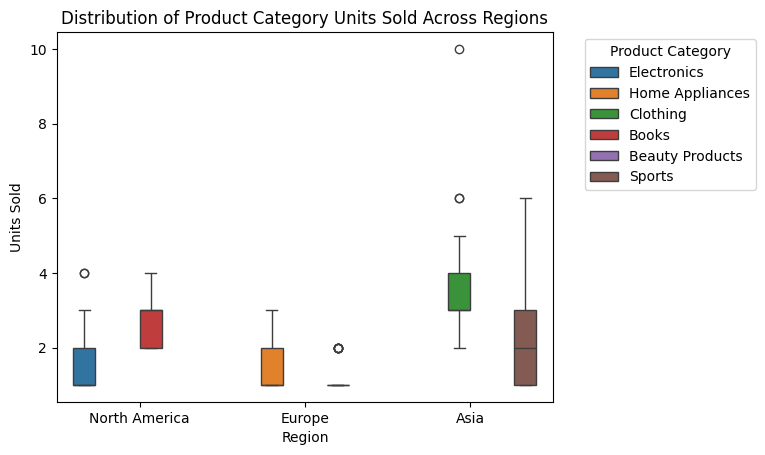

In [12]:
# I also want to check the distribution of units sold for each region to help me determine the marketing campaigns

# I think the best way to visualize is through a box plot
sns.boxplot(x='Region', y='Units Sold', hue='Product Category', data=df)
plt.title('Distribution of Product Category Units Sold Across Regions')
plt.xlabel('Region')
plt.ylabel('Units Sold')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Interpretation on region performance:


*   Each region can determine their own focus on whether they want to optimize for revenue or quantity (units sold) metrics
*   For example, North America might want to focus on selling electronics only as they bring the most revenue while keeping a low stock


## Payment Method Analysis

In [13]:
## Pattern by Month
cursor = conn.cursor()
query_method_by_month = """CREATE TABLE IF NOT EXISTS total_transaction_by_method_by_month AS
SELECT
    STRFTIME('%Y-%m', "Date") AS month,
    SUM(CASE WHEN "Payment Method" = 'Credit Card' THEN 1 ELSE 0 END) AS count_transaction_creditcard,
    SUM(CASE WHEN "Payment Method" = 'Debit Card' THEN 1 ELSE 0 END) AS count_transaction_debitcard
FROM ecommerce
GROUP BY month
ORDER BY month"""

with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_method_by_month)
    df_method_by_month = pd.read_sql_query("SELECT * FROM total_transaction_by_method_by_month", conn)
    print(df_method_by_month)

     month  count_transaction_creditcard  count_transaction_debitcard
0  2024-01                            16                            5
1  2024-02                            14                            5
2  2024-03                            16                            5
3  2024-04                            15                            5
4  2024-05                            15                            5
5  2024-06                            15                            5
6  2024-07                            15                            6
7  2024-08                            14                            4


In [14]:
# Sorry I forgot to add PayPal lol
query_add_column = """
ALTER TABLE total_transaction_by_method_by_month
ADD COLUMN count_transaction_paypal INTEGER;
"""

query_update_column = """
UPDATE total_transaction_by_method_by_month
SET count_transaction_paypal = (
    SELECT SUM(CASE WHEN "Payment Method" = 'PayPal' THEN 1 ELSE 0 END)
    FROM ecommerce
    WHERE STRFTIME('%Y-%m', ecommerce."Date") = total_transaction_by_method_by_month.month
);
"""
with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_add_column)
    conn.execute(query_update_column)
    df_method_by_month = pd.read_sql_query("SELECT * FROM total_transaction_by_method_by_month", conn)
    print(df_method_by_month)

     month  count_transaction_creditcard  count_transaction_debitcard  \
0  2024-01                            16                            5   
1  2024-02                            14                            5   
2  2024-03                            16                            5   
3  2024-04                            15                            5   
4  2024-05                            15                            5   
5  2024-06                            15                            5   
6  2024-07                            15                            6   
7  2024-08                            14                            4   

   count_transaction_paypal  
0                        10  
1                        10  
2                        10  
3                        10  
4                        11  
5                        10  
6                        10  
7                         9  


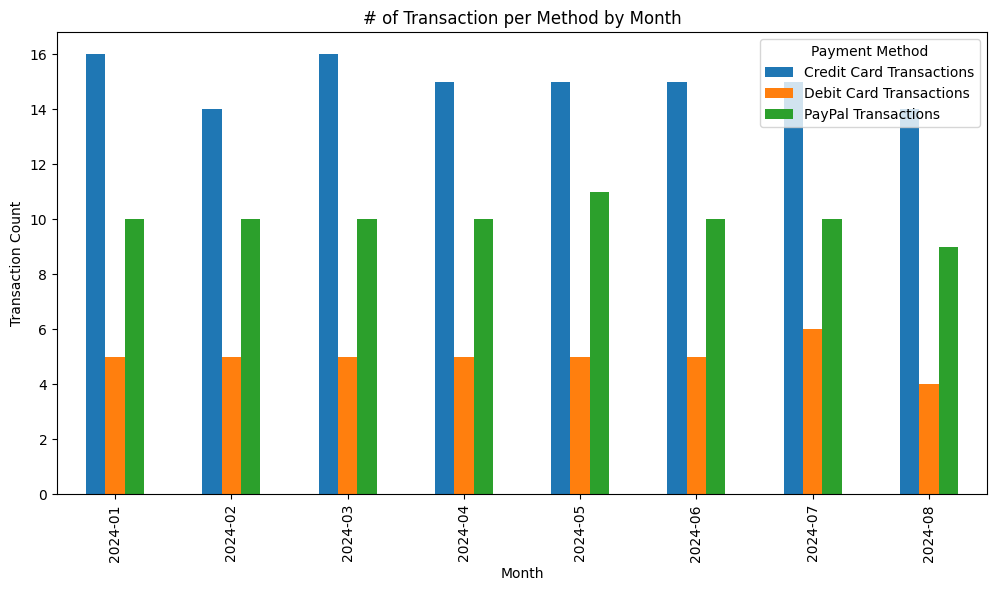

In [15]:
# I want to visualize it so we can see the trends better
method_month = df_method_by_month.groupby('month')[['count_transaction_creditcard','count_transaction_debitcard','count_transaction_paypal']].sum()
method_month .plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('# of Transaction per Method by Month')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
legend_labels = ['Credit Card Transactions', 'Debit Card Transactions', 'PayPal Transactions']
plt.legend(title='Payment Method',labels=legend_labels)
plt.show()

Ok, seems the usage of payment method across months are pretty similar.

In [16]:
## Pattern by Product
query_method_by_product = """CREATE TABLE IF NOT EXISTS total_transaction_by_method_by_category AS
SELECT
    "Product Category",
    SUM(CASE WHEN "Payment Method" = 'Credit Card' THEN 1 ELSE 0 END) AS count_transaction_creditcard,
    SUM(CASE WHEN "Payment Method" = 'Debit Card' THEN 1 ELSE 0 END) AS count_transaction_debitcard,
    SUM(CASE WHEN "Payment Method" = 'PayPal' THEN 1 ELSE 0 END) AS count_transaction_paypal
FROM ecommerce
GROUP BY "Product Category"
ORDER BY "Product Category" """

with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_method_by_product)
    df_method_by_category = pd.read_sql_query("SELECT * FROM total_transaction_by_method_by_category", conn)
    print(df_method_by_category)

  Product Category  count_transaction_creditcard  count_transaction_debitcard  \
0  Beauty Products                             0                            0   
1            Books                            40                            0   
2         Clothing                             0                           40   
3      Electronics                            40                            0   
4  Home Appliances                             0                            0   
5           Sports                            40                            0   

   count_transaction_paypal  
0                        40  
1                         0  
2                         0  
3                         0  
4                        40  
5                         0  


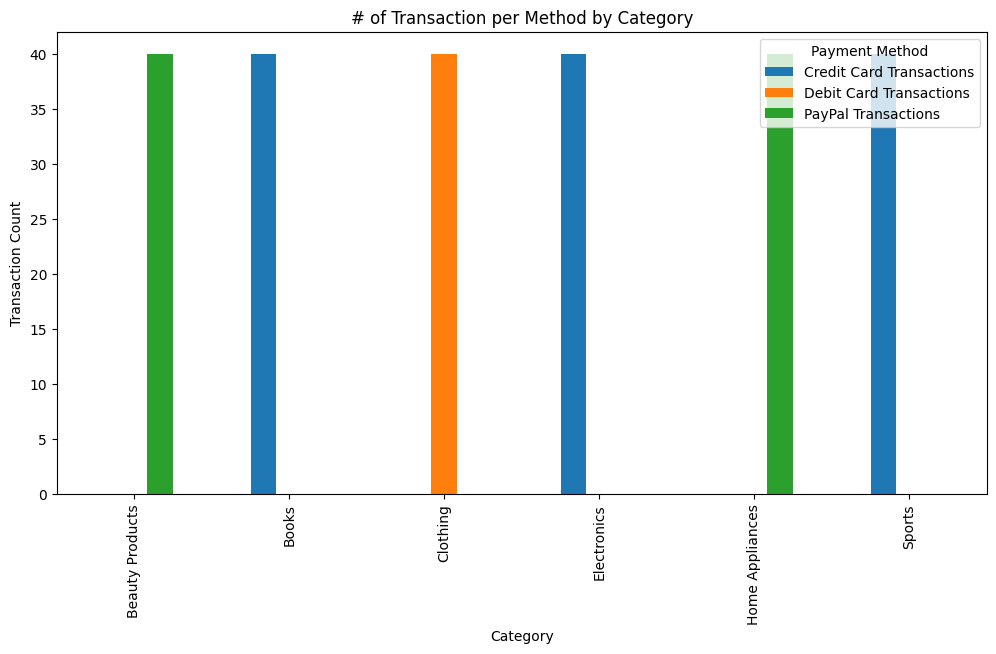

In [17]:
method_month = df_method_by_category.groupby('Product Category')[['count_transaction_creditcard','count_transaction_debitcard','count_transaction_paypal']].sum()
method_month .plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('# of Transaction per Method by Category')
plt.xlabel('Category')
plt.ylabel('Transaction Count')
legend_labels = ['Credit Card Transactions', 'Debit Card Transactions', 'PayPal Transactions']
plt.legend(title='Payment Method',labels=legend_labels)
plt.show()



*   PayPal popular for -> Beauty & Home
*   Credit Card popular for -> Books, Electronics, and Sports
*   Debit Card popular for -> Clothing





In [18]:
## AOV per Payment Method
query_average_order_value = """CREATE TABLE IF NOT EXISTS average_order_value_per_method AS
SELECT
    "Payment Method",
    AVG("Total Revenue") AS average_order_value
FROM ecommerce
GROUP BY "Payment Method"
ORDER BY "Payment Method";"""

with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_average_order_value)
    df_average_order_value = pd.read_sql_query("SELECT * FROM average_order_value_per_method", conn)
    print(df_average_order_value)

  Payment Method  average_order_value
0    Credit Card           426.423833
1     Debit Card           203.223250
2         PayPal           265.850750


In [34]:
## Revenue Contribution per Method

# I will create CTE for total_revenue_by_method and overall_revenue
query_revenue_contribution = """CREATE TABLE IF NOT EXISTS revenue_contribution_by_method AS
WITH total_revenue_by_method AS (
    SELECT
        "Payment Method",
        SUM("Total Revenue") AS total_revenue
    FROM ecommerce
    GROUP BY "Payment Method"
),
overall_revenue AS (
    SELECT
        SUM("Total Revenue") AS overall_total
    FROM ecommerce
)
SELECT
    trm."Payment Method",
    trm.total_revenue,
    (trm.total_revenue * 100.0 / otr.overall_total) AS percentage_contribution
FROM total_revenue_by_method AS trm, overall_revenue AS otr
ORDER BY trm."Payment Method";"""

with sqlite3.connect('ecommerce.db') as conn:
    conn.execute(query_revenue_contribution)
    df_revenue_contribution = pd.read_sql_query("SELECT \"Payment Method\", total_revenue, formatted_percentage_contribution FROM revenue_contribution_by_method", conn)
    print(df_revenue_contribution)

  Payment Method  total_revenue formatted_percentage_contribution
0    Credit Card       51170.86                            63.51%
1     Debit Card        8128.93                            10.09%
2         PayPal       21268.06                             26.4%


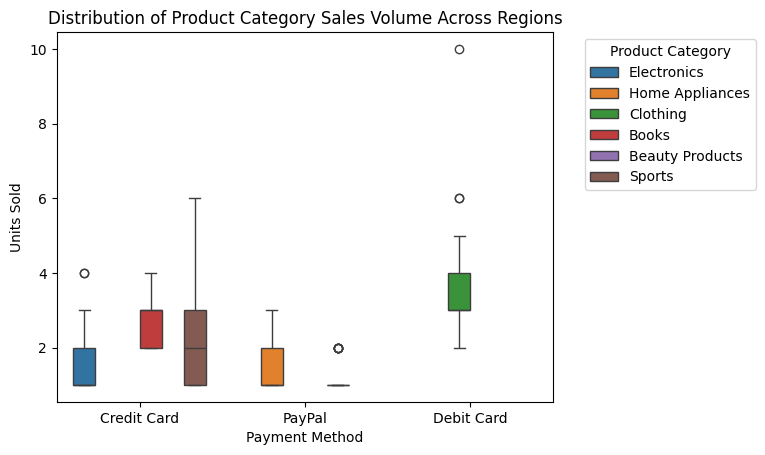

In [35]:
## Visualizing Units Sold distribution based on Payment Method
sns.boxplot(x='Payment Method', y='Units Sold', hue='Product Category', data=df)
plt.title('Distribution of Product Category Sales Volume Across Regions')
plt.xlabel('Payment Method')
plt.ylabel('Units Sold')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

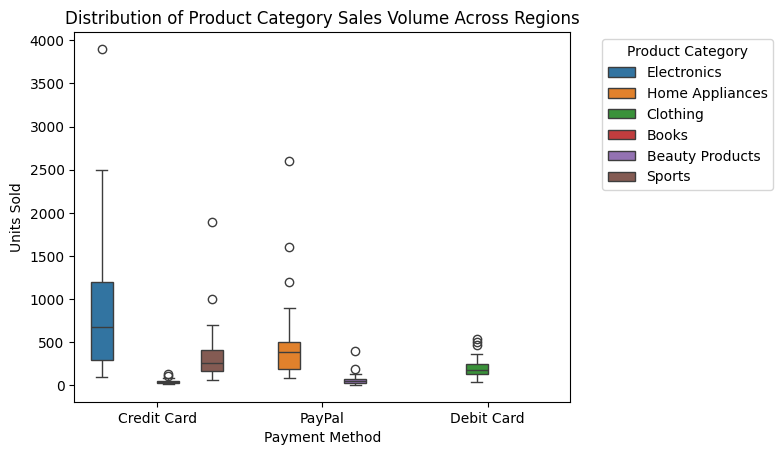

In [36]:
## Visualizing Order Value distribution based on Payment Method
sns.boxplot(x='Payment Method', y='Total Revenue', hue='Product Category', data=df)
plt.title('Distribution of Product Category Sales Volume Across Regions')
plt.xlabel('Payment Method')
plt.ylabel('Units Sold')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Interpretation on Payment Method Analysis:

*   Credit cards and debit cards are used for higher volumes of sales compared to PayPal (mainly used for higher-value items like electronics and sports).
*   PayPal transactions are relatively consistent and involve fewer units per sale.
*   PayPal transactions shows potential of high-value transaction from Home Appliances, like credit cards.
*   Debit card method for clothing shows consistent number of sales volume


Interpretation on Growth Opportunities will be discussed in later part



## Correlation Between Payment Method & AOV
Here I will do a correlation test using Pearson & Spearman correlation. This will help me set the basis to determine if sales & marketing campaigns should move towards a payment method specific campaign to increase AOV.



In [41]:
# Importing the necessary packages
from scipy.stats import pearsonr, spearmanr

# Encode payment method as numerical values
df_average_order_value['Payment Method Code'] = df_average_order_value['Payment Method'].map({'Credit Card': 1, 'Debit Card': 2, 'PayPal': 3})

# Correlation test
pearson_corr, pearson_p_value = pearsonr(df_average_order_value['Payment Method Code'], df_average_order_value['average_order_value'])
spearman_corr, spearman_p_value = spearmanr(df_average_order_value['Payment Method Code'], df_average_order_value['average_order_value'])

print("Pearson Correlation Coefficient:", pearson_corr)
print("Pearson P-value:", pearson_p_value)
print("Spearman Correlation Coefficient:", spearman_corr)
print("Spearman P-value:", spearman_p_value)


Pearson Correlation Coefficient: -0.697377808166478
Pearson P-value: 0.5086999783770505
Spearman Correlation Coefficient: -0.5
Spearman P-value: 0.6666666666666667


Interpration on correlation:

General note:


*   **Spearman Correlation Coefficient:** Measures the rank-order relationship
*   **Pearson Correlation Coefficient:** Measures the linear
relationship
*   **P-value:** Indicates the significance of the correlation. A low p-value (typically < 0.05) suggests that the observed correlation is statistically significant.


Interpretation:
*   Pearson correlation shows a negative linear relationship between method & AOV, however it is not statistically significant
*   Spearman correlation shows a negative rank-order relationship between method & AOV, it is also not statistically significant

Summary:


*   Payment method doesn't affect AOV that much, however further investigation is required by using more data or testing the correlation of AOV with other variables

*   Although in this test it is not statistically significant, we can test AOV again with a specific customer segmentation (e.g. AOV for customer with preferred payment method - we don't have this data tho)


*   In the previous analysis stored in df_average_order_value, we can also take notes that Credit Card brings higher AOV - we can consider similar Credit or Pay Later payment methods to high-price unit items











## Campaign Recomendation

### 1. Target High-Value Category/Products with Credit Cards:


*   Electronics can be an entry point here, given its high median sales and potential for large transactions
*   Sports also shows potential like electronics, just not as high
*   Consider to partner with banks to provide low interest rate for high value products
*   Consider to create promo and loyalty programs to capitalize high-value customers
*   Consider to create campaign for brand awereness with Eletronics and Sports brands to gain more traffic for these type of purchases



### 2. Optimize PayPal to increase AOV


*   Home appliances purchase with PayPal has shown potential for higher sales
*   We can test by creating special promo for high-value products with PayPal, just like what we are doing with Credit Card
*   Consider to partner with PayPal's BNPL to offer low interest and cashbacks for high-value products

### 3. Build Promo Around Clothing Purchase with Debit Card to Increase Sales Volume

*   Customer's are using debit card to purchase clothes, no matter in how many quantities
*   To increase sales volume, we can create campaign for discounts, cashback, loyalty points for every > 5 item purchase

### 4. Bundle Products to Increase AOV
*   Bundle products from high-performing categories (e.g. Electronics and Sports) to increase average order value.
*   Need to test and analyze to check whether they can be sold as a bundle or not











